<img width="1200px" class="center-block" src="docs/transport/welcome.png">

<img width="1200px" class="center-block" src="docs/transport/toc.png">

<img width="1200px" class="center-block" src="docs/transport/pres_1.png">

<img width="1200px" class="center-block" src="docs/transport/pres_2.png">


<img width="1200px" class="center-block" src="docs/transport/pres_3.png">

![Hello](docs/transport/explore.png)

<img width="1200px" class="center-block" src="docs/transport/osm.png">

## Stats: State of the city

In [22]:
import warnings
warnings.filterwarnings('ignore')
std_kwargs = {
    "figsize":(25, 25),
    "legend":True,
    "legend_kwds":dict(loc="upper left", ncol=3, bbox_to_anchor=(1, 1)),
}

<Axes: >

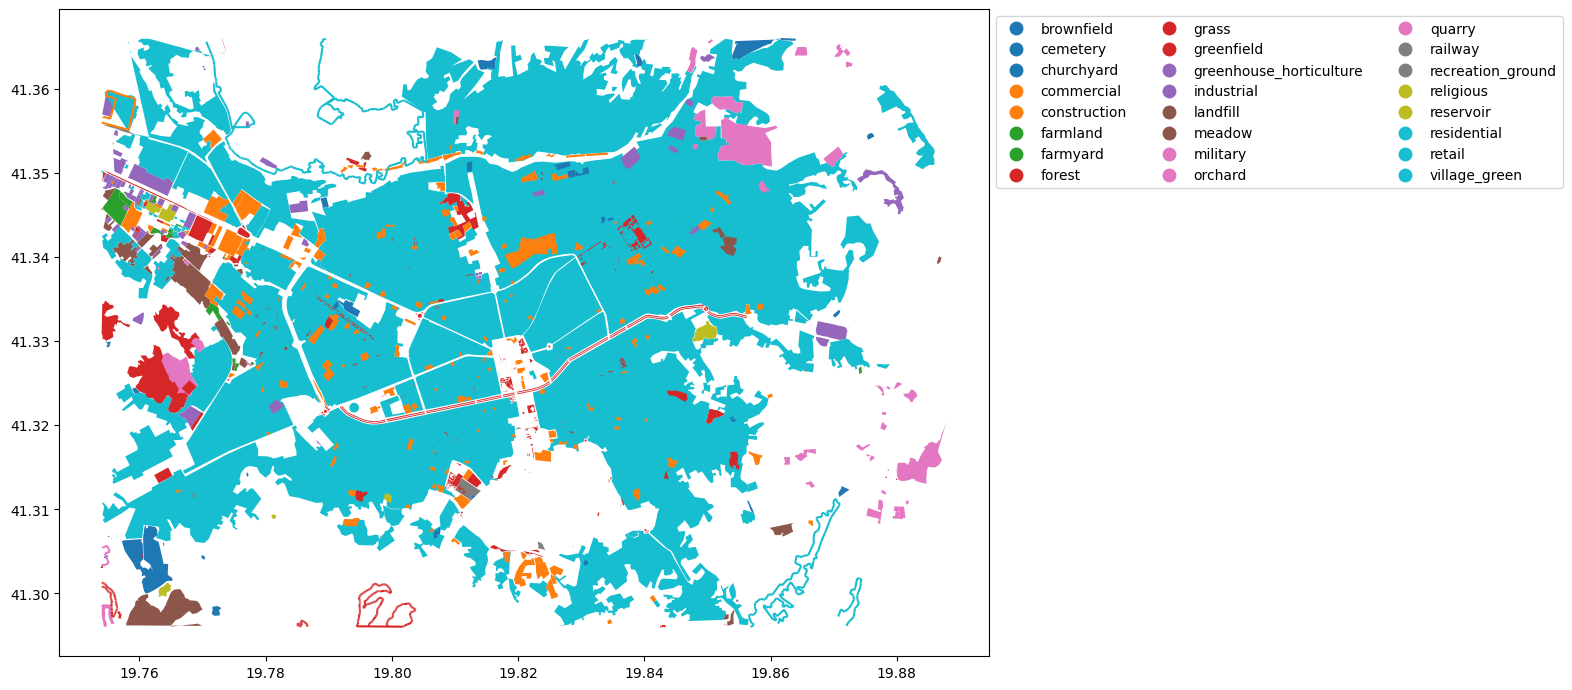

In [15]:
from pyrosm import OSM, get_data
osm = OSM(filepath="data/tirana.pbf")
landuse = osm.get_landuse()
landuse.plot(column="landuse", **std_kwargs)


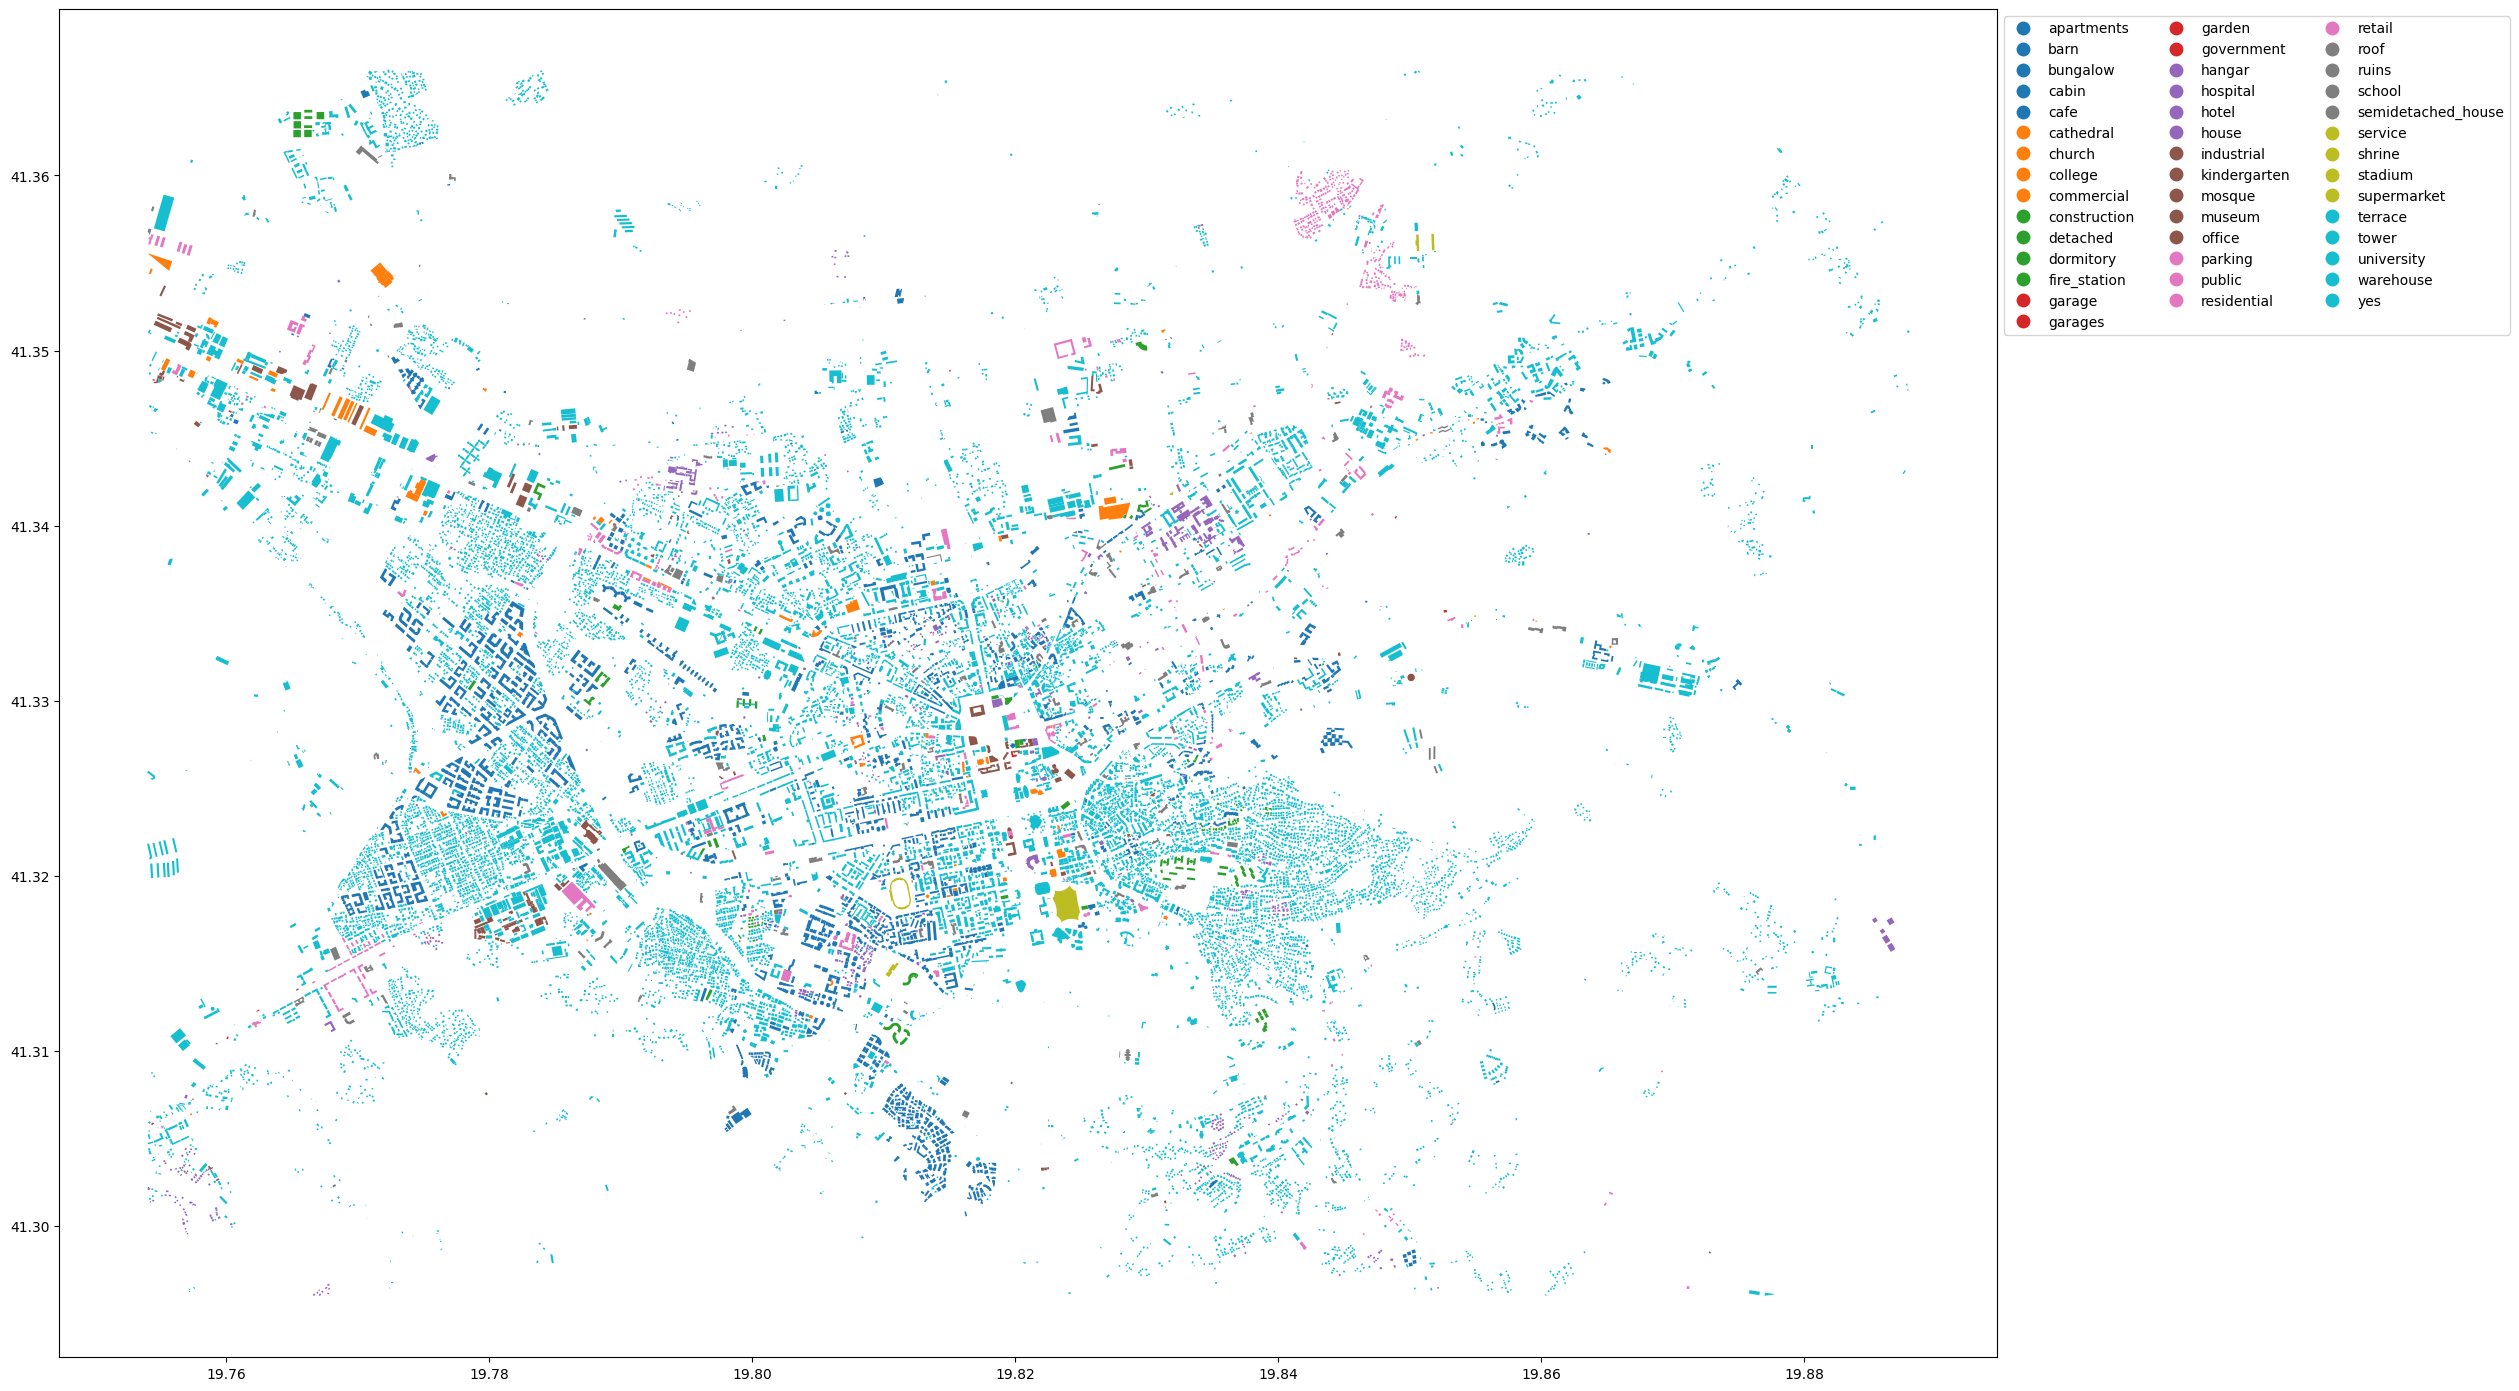

In [16]:
buildings = osm.get_buildings()
ax = buildings.plot(column="building", **std_kwargs)


## State of Transit

In [20]:
# Test reading all transit related data (bus, trains, trams, metro etc.)
# Exclude nodes (not keeping stops, etc.)
routes = [
    "bus", "ferry", "railway", "subway", "train", "tram", "trolleybus"]
rails = ["tramway", "light_rail", "rail", "subway", "tram"]
bus = ["yes"]
transit = osm.get_data_by_custom_criteria(
    custom_filter={
        "route": routes,
        "railway": rails,
        "bus": bus,
        "public_transport": True,
    },
    # Keep data matching the criteria above
    filter_type="keep",
    # Do not keep nodes (point data)
    keep_nodes=True,
    keep_ways=True,
    keep_relations=True,
)

<Axes: >

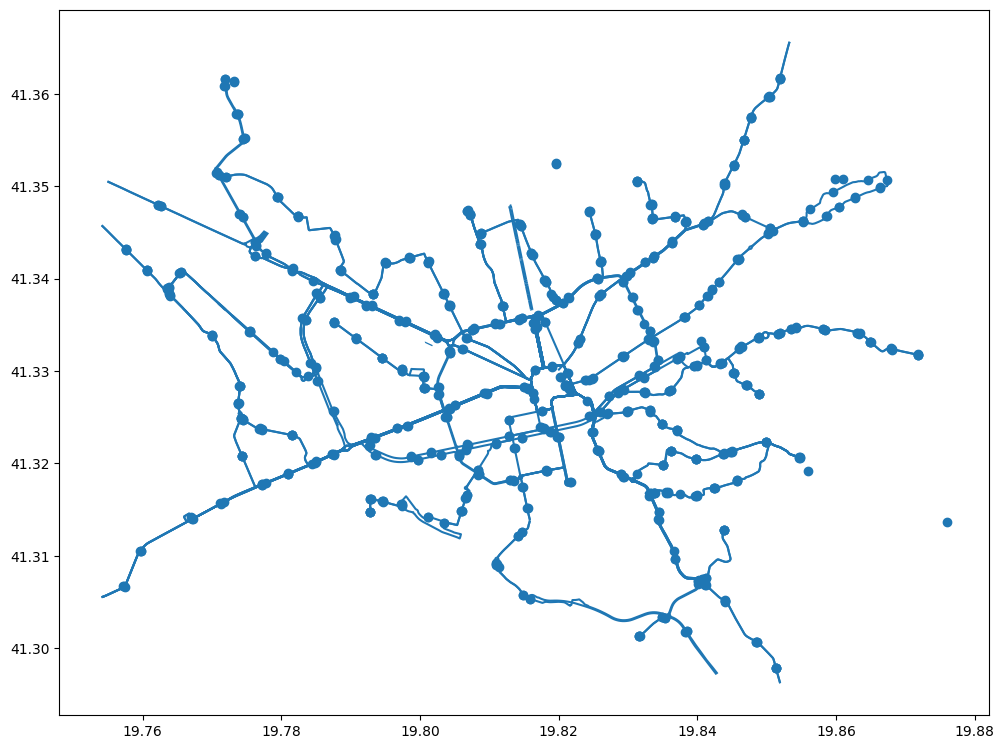

In [21]:
transit.plot(**std_kwargs)


<Axes: >

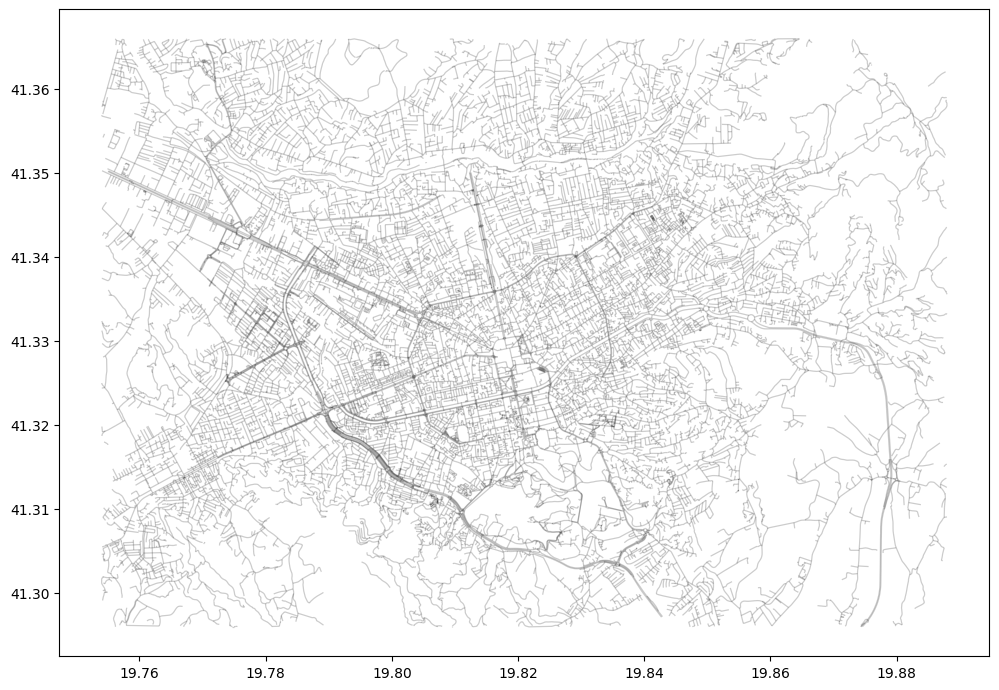

In [19]:
# Apply the same bounding box filter and retrieve walking network
walk = osm.get_network("walking")
walk.plot(color="k", lw=0.9,  alpha=0.2, **std_kwargs)


## State of road networks!

In [40]:
import networkx as nx
import osmnx as ox
import pandas as pd

def get_stats_for_place(place):
    gdf = ox.geocode_to_gdf(place)
    area = ox.project_gdf(gdf).unary_union.area
    G = ox.graph_from_place(place, network_type="drive")

    # calculate basic and extended network stats, merge them together, and display
    stats = ox.basic_stats(G, area=area)
    for k, count in stats["streets_per_node_counts"].items():
        stats[f"{k}way_int_count"] = count
    for k, proportion in stats["streets_per_node_proportions"].items():
        stats[f"{k}way_int_prop"] = proportion

    # delete the no longer needed dict elements
    del stats["streets_per_node_counts"]
    del stats["streets_per_node_proportions"]
    return stats


In [39]:
# get the street network for a place, and its area in square meters
places = ["Tirana, Albania", "Durres, Albania", "Elbasan, Albania", "Shkoder, Albania"]

infinite_time = False  # not for running multiple times
if infinite_time:
    data = []
    for place in places:
        print(f"Working on {place}...")
        data.append(get_stats_for_place(place))
    all_df = pd.DataFrame(data)
    all_df.index = places
    all_df.to_csv('data/network-run.csv')
    display(all_df)
else:
    all_df = pd.read_csv('data/network-run.csv', index_col=0)
all_df

,n,m,k_avg,edge_length_total,edge_length_avg,streets_per_node_avg,intersection_count,street_length_total,street_segment_count,street_length_avg,...,2way_int_count,3way_int_count,4way_int_count,5way_int_count,0way_int_prop,1way_int_prop,2way_int_prop,3way_int_prop,4way_int_prop,5way_int_prop
"Tirana, Albania",6657,14277,4.289320,1051280.430,73.634547,2.510590,4829,616092.094,8269,74.506239,...,70,4298,454,7.0,0.0,0.274598,0.010515,0.645636,0.068199,0.001052
"Durres, Albania",3523,8286,4.703946,804217.552,97.057392,2.543287,2585,436423.011,4454,97.984511,...,11,2298,274,2.0,0.0,0.266250,0.003122,0.652285,0.077775,0.000568
"Elbasan, Albania",1654,4062,4.911729,371970.123,91.573147,2.602177,1241,191961.137,2131,90.080308,...,1,1073,165,2.0,0.0,0.249698,0.000605,0.648730,0.099758,0.001209
"Shkoder, Albania",2031,4405,4.337765,335608.415,76.188062,2.358936,1349,181444.820,2391,75.886583,...,5,1277,67,NaN,0.0,0.335795,0.002462,0.628754,0.032989,NaN


## Example stat: Betweenness

In [41]:
# get the street network for a place, and its area in square meters
place = "Tirana, Albania"
gdf = ox.geocode_to_gdf(place)
area = ox.project_gdf(gdf).unary_union.area
G = ox.graph_from_place(place, network_type="drive")

# calculate betweenness with a digraph of G (ie, no parallel edges)
bc = nx.betweenness_centrality(ox.get_digraph(G), weight="length")

# add the betweenness centraliy values as new node attributes, then plot
nx.set_node_attributes(G, bc, "bc")
nc = ox.plot.get_node_colors_by_attr(G, "bc", cmap="plasma")

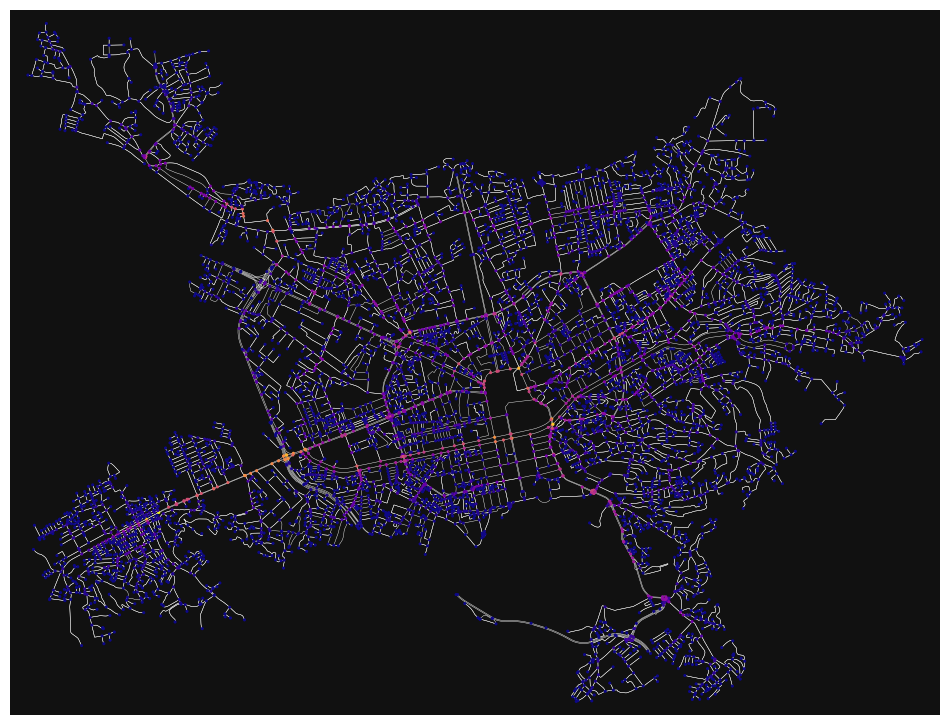

In [47]:
fig, ax = ox.plot_graph(
    G,
    node_color=nc,
    node_size=5,
    node_zorder=2,
    edge_linewidth=0.3,
    edge_color="w",
    figsize=(12, 12)
)

In [1]:
## Routing and Navigation

## Routing and Navigation 

- **Open Route Service** (ORS): A high-performance routing engine specifically designed for OpenStreetMap data.
- **Valhalla**: A routing engine that offers multimodal routing options for different transportation modes.
- **MapQuest**: An open-source mapping service that provides directions and geocoding APIs.
- **OpenTripPlanner**: An open-source multimodal trip planning and routing engine.
- **GraphHopper**: A routing engine that supports vehicle, pedestrian, and bicycle routing.


## Data Processing and Analysis:

- **Pandas**: A powerful data manipulation and analysis library for Python.
- **GeoPandas**: A Python library for geospatial data manipulation and analysis.
- **QGIS**: A powerful open-source desktop GIS software for geospatial data analysis and visualization.


## Data Visualization and Analysis:

- **Leaflet**: A JavaScript library for interactive maps that can be easily integrated into web applications.
- **Kepler.gl**: A powerful open-source geospatial analysis tool for visualizing large-scale geospatial datasets.
- **Deck.gl**: A WebGL-powered data visualization framework for large-scale geospatial data.
- **Grafana**: A platform for 

In [48]:
# !git clone https://github.com/pomodoren/open-labs.git; cd open-labs;
!cat setup/requirements_transport.txt

# presentation
jupyterlab
rise

# plotting
matplotlib

# stats
osmnx
pandas
geopandas
movingpandas
pyrosm
numpy<1.24
shapely<2.0

